# Versed plays in RusDraCor

In [1]:
import json
import requests

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [2]:
from lxml import etree

# we need this parameter to search in TEI-encoded files correctly
tei_ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

## 1 &emsp; Getting data

Extracting all the plays from the DraCor API:

In [15]:
playnames = []
request_link = "https://dracor.org/api/corpora/rus"
response = requests.get(request_link)
if response:
    all_plays = response.json()["dramas"]
    for play in all_plays:
        playnames.append(play["name"])

In [4]:
def download_play_text(playname):
    req_link = "https://dracor.org/api/corpora/rus/play/{}/tei".format(playname)
    text = requests.get(req_link).text
    return text

In [5]:
def calculate_p_l(text):
    root = etree.fromstring(text)
    try:
        p_len = len(root.findall(".//tei:p", tei_ns))
    except:
        p_len = 0
    try:
        l_len = len(root.findall(".//tei:l", tei_ns))
    except:
        l_len = 0
    return p_len, l_len

Adding metadata:

In [11]:
def play_metadata_api(playname):
    """Fetch play metadata from DraCor API, including:
        play title,
        playwriter's full name (important to distinguish between Leo Tolstoy and 
    Alexey Tolstoy),
        no. of characters in cast,
        no. of segments.
    In case the request returns with error code, returns an empty dict.
    :arg play_id - (str) id of the play from RusDraCor (extracted from the API)
    to insert in the API request
    :returns play_data - (dict) fetched data from API query results:
        title: str, 
        author: str, 
        year: int
    """
    request_link = "https://dracor.org/api/corpora/rus/play/{}".format(playname)
    response = requests.get(request_link)
    if response.status_code == 200:
        response_json = json.loads(response.text)
        title = response_json["title"]
        author = response_json["author"]["name"]
        year = int(response_json["yearNormalized"])
    else:
        print("Couldn't retrieve metadata\n\t- play: {}\n\t- status code: {}".format(playname, response.status_code))
        print(request_link)
        title = ""
        author = ""
        year = 0
    return title, author, year

In [35]:
df_dict = {
    "name": [], 
    "author": [],
    "title": [],
    "year": [],
    "p": [], 
    "l": [], 
    "verse":[]
}

In [40]:
playtexts = []
for playname in playnames:
    playtext = download_play_text(playname)
    playtexts.append(playtext)

In [41]:
playdata = []
for playname in playnames:
    playd = play_metadata_api(playname)
    playdata.append(playd)

In [44]:
for i, playname in enumerate(playnames):
    df_dict["name"].append(playname)
    playtext = playtexts[i]
    p, l = calculate_p_l(playtext)
    df_dict["p"].append(p)
    df_dict["l"].append(l)
    if l > p:
        decision = True
    else:
        decision = False
    df_dict["verse"].append(decision)
    playd = playdata[i]
    df_dict["title"].append(playd[0])
    df_dict["author"].append(playd[1])
    df_dict["year"].append(playd[2])

In [32]:
%%time
df_dict = {
    "name": [], 
    "author": [],
    "title": [],
    "year": [],
    "p": [], 
    "l": [], 
    "verse":[]
}
for playname in playnames:
    playtext = download_play_text(playname)
    title, author, year = play_metadata_api(playname)
        
    df_dict["title"].append(title)
    df_dict["author"].append(author)
    df_dict["year"].append(year)
#     print("Play: {}, author: {}, year: {}, playname: {}\np={}, l={}, decision: {}".format(
#         title, author, year, playname, p, l, decision))

CPU times: user 13.9 s, sys: 1.01 s, total: 14.9 s
Wall time: 4min 11s


In [46]:
df = pd.DataFrame.from_dict(df_dict)
df.head()

,name,author,title,year,p,l,verse
0,andreyev-ne-ubiy,"Андреев, Леонид Николаевич",Не убий,1913,973,0,False
1,andreyev-mysl,"Андреев, Леонид Николаевич",Мысль,1914,669,0,False
2,afinogenov-mashenka,"Афиногенов, Александр Николаевич",Машенька,1941,828,4,False
3,babel-marija,"Бабель, Исаак Эммануилович",Мария,1935,574,22,False
4,babel-zakat,"Бабель, Исаак Эммануилович",Закат,1927,635,24,False


## 2 &emsp; Figures and stats

General distribution:

In [47]:
df["verse"].value_counts()

False    122
True      68
Name: verse, dtype: int64

Type distribution by year:

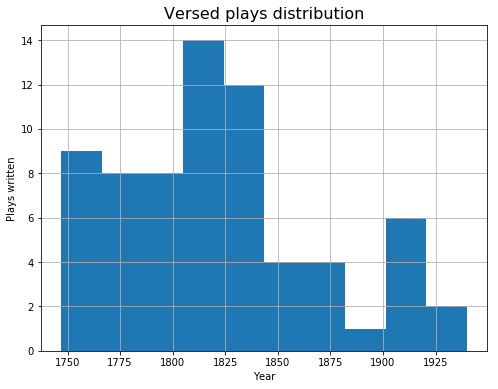

In [52]:
plt.figure(figsize=(8,6))
df[df["verse"] == True]["year"].hist()
plt.title("Versed plays distribution", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Plays written");

Looks like the versed dramas are more likely to appear either _until second half of 19th century_ (when the classics canon was still strong, see Sperantov 1998) or _in the 20th century_.

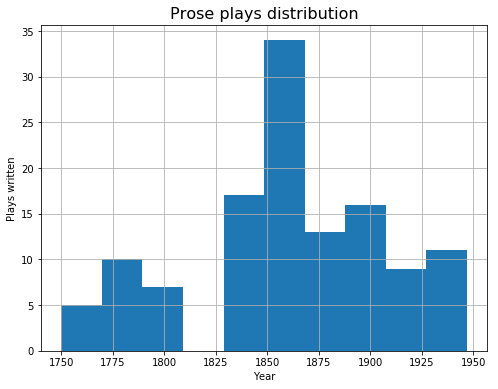

In [51]:
plt.figure(figsize=(8,6))
df[df["verse"] == False]["year"].hist()
plt.title("Prose plays distribution", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Plays written");

Authors who wrote versed drama, sorted by amount of plays:

In [53]:
df[df["verse"] == True]["author"].value_counts()

Пушкин, Александр Сергеевич           6
Княжнин, Яков Борисович               6
Сумароков, Александр Петрович         6
Гумилёв, Николай Степанович           4
Хмельницкий, Николай Иванович         4
Шаховской, Александр Александрович    4
Писарев, Александр Иванович           3
Крылов, Иван Андреевич                3
Толстой, Алексей Константинович       3
Прутков, Козьма                       3
Ломоносов, Михаил Васильевич          2
Некрасов, Николай Алексеевич          2
Майков, Василий Иванович              2
Грибоедов, Александр Сергеевич        2
Херасков, Михаил Матвеевич            2
Капнист, Василий Васильевич           2
Блок, Александр Александрович         2
Кокошкин, Фёдор Фёдорович             1
Ростопчина, Евдокия Петровна          1
Кедрин, Дмитрий Борисович             1
Загоскин, Михаил Николаевич           1
Судовщиков, Николай Родионович        1
Николев, Николай Петрович             1
Глинка, Фёдор Николаевич              1
Маяковский, Владимир Владимирович     1
